In [1]:
import pandas as pd
import numpy as np

In [2]:
with open("tweets_AAPL.csv",'rb') as dfile:
    dstr = str(dfile.read())[1:5]

Open, High, Low, Close, Adj Close

In [3]:
%%time
with open("tweets_AAPL.csv",'rb') as dfile:
    dstr = str(dfile.read())[2:]
darr = dstr.split('\\r')
dmat = [rs.split(",") for rs in darr]
dmat = [r[:1] + [",".join(r[1:-5])] + r[-5:] for r in dmat]
dmat = [r for r in dmat if len(r) == 7]
df = pd.DataFrame(dmat)
df.columns = ["datestr","twt","open","high","low","close","adjclose"]
df["twtarr"] = df["twt"].apply(lambda text: text.lower().split())

CPU times: user 4.13 s, sys: 772 ms, total: 4.9 s
Wall time: 9.8 s


In [4]:
from datetime import datetime

In [5]:
df = df[df["datestr"] != ""]
%time df["date"] = df["datestr"].apply( \
    lambda date: datetime.strptime(date,"%m/%d/%y"))
datedf = df[["date","open"]].groupby("date").aggregate(lambda gp: tuple(set(gp))[0])
pval = datedf.values.astype(float)
up = ((pval[1:] - pval[:-1]) > 0).astype(int)
datedf["openup"] = list(up.T[0]) + [0]

CPU times: user 5.44 s, sys: 151 ms, total: 5.59 s
Wall time: 10.3 s


In [19]:
%time df["openup"] = df["date"].apply(lambda date: datedf["openup"].loc[date])

CPU times: user 19.3 s, sys: 1.48 s, total: 20.8 s
Wall time: 33.4 s


In [20]:
import gensim
%time w2vM = gensim.models.Word2Vec(df["twtarr"])

CPU times: user 1min 3s, sys: 1.22 s, total: 1min 5s
Wall time: 53.9 s


In [21]:
# number of samples to aggregate
Ns = int(1e6)

In [22]:
%%time
# MEAN AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).mean(axis=0)
#                  for twt in df["twtarr"][:Ns]])
# tvecs = np.array([np.array([w2vM[t]
#                             for t in twt
#                             if t in w2vM]).mean(axis=0)
#                  for twt in df["twt"][:Ns]])
# SUM AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).sum(axis=0)
#                  for twt in sentDf["SentimentText"][:Ns]])
# MEAN AGGREGATION
%time df["twtvecs"] = df["twtarr"][:Ns].apply(\
    lambda twt: np.array([w2vM[t] \
                         if t in w2vM else np.zeros((100,)) \
                         for t in twt]).mean(axis=0))

CPU times: user 32.9 s, sys: 1.65 s, total: 34.6 s
Wall time: 58.8 s
CPU times: user 32.9 s, sys: 1.65 s, total: 34.6 s
Wall time: 58.8 s


In [23]:
print(df.shape)
%time veclens = df["twtvecs"].apply(lambda vec: int(np.prod(vec.shape)))
df_empty = df[veclens != 100]
%time df = df[veclens == 100]
print(df.shape)

(221343, 11)
CPU times: user 3.14 s, sys: 197 ms, total: 3.33 s
Wall time: 6.12 s
CPU times: user 68.9 ms, sys: 127 ms, total: 196 ms
Wall time: 390 ms
(221343, 11)


In [24]:
dategps = df[["date","twtvecs"]].groupby("date")
datevecs = [np.mean(gp.values[:,1], axis=0) for k,gp in dategps]
datedf["datevecs"] = datevecs

In [25]:
import sklearn
from sklearn import ensemble,svm,neural_network,discriminant_analysis
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from matplotlib import pyplot as plt
% matplotlib inline

def roc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_str = 'ROC (AUC Gain = %0.2f)' % (roc_auc - 0.5)
    plt.plot(fpr, tpr, lw=1,label=roc_str)
    plt.plot([0,1],[0,1],label="RAN CLF")
    plt.title(roc_str)
    plt.show()

def prrc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    pr, rc, thresholds = precision_recall_curve(y, probs[:, 1])
    roc_auc = auc(rc, pr)
    roc_str = 'Prec vs Recall (AUC Gain = %0.2f)' % (roc_auc - np.mean(y))
    plt.plot(rc,pr, lw=1,label=roc_str)
    plt.plot([0,1],[np.mean(y),np.mean(y)],label="RAN CLF")
    plt.axis([0,1,0,1])
    plt.title(roc_str)
    plt.show()

def evaluate(clf,X,y):
    yhat = clf.predict(X)
    accu = np.mean(yhat == y)
    prec = np.mean(y[yhat == 1])
    recl = np.mean(yhat[y == 1])
    f1 = 2 * prec * recl / (prec + recl)
    print("Accuracy",accu,"Precision",prec,"Recall",recl,"F1",f1)

# Average of tweets in a day

In [26]:
# dvecs = np.array([vec.T for vec in avgvecs["vecs"].values])
X = np.array([vec.T for vec in datedf["datevecs"].values])
y = datedf["openup"].values
# inverse classifier
# y = 1 - y

In [27]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(X.shape[0]) < ratio
pidx = ~tidx

CPU times: user 33.5 ms, sys: 5.68 ms, total: 39.1 ms
Wall time: 60.8 ms
TEST
Accuracy 0.5 Precision 0.516129032258 Recall 0.615384615385 F1 0.561403508772
CPU times: user 4.52 ms, sys: 1.48 ms, total: 6 ms
Wall time: 7.75 ms
TRAIN
Accuracy 0.919786096257 Precision 0.897435897436 Recall 0.972222222222 F1 0.933333333333
CPU times: user 3.95 ms, sys: 1.33 ms, total: 5.28 ms
Wall time: 5.61 ms
ROC AUC


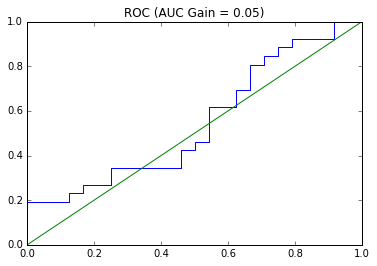

CPU times: user 297 ms, sys: 28.5 ms, total: 326 ms
Wall time: 569 ms
PRECISION/RECALL AUC


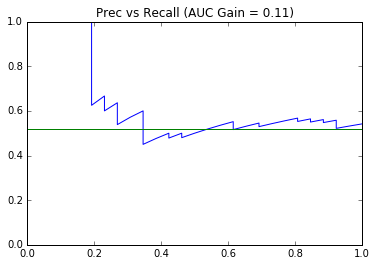

CPU times: user 276 ms, sys: 11 ms, total: 287 ms
Wall time: 575 ms


In [28]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 19.3 ms, sys: 6.24 ms, total: 25.6 ms
Wall time: 36.3 ms
TEST
Accuracy 0.52 Precision 0.52 Recall 1.0 F1 0.684210526316
CPU times: user 2.8 ms, sys: 1.06 ms, total: 3.86 ms
Wall time: 5.11 ms
TRAIN
Accuracy 0.577540106952 Precision 0.577540106952 Recall 1.0 F1 0.732203389831
CPU times: user 3.44 ms, sys: 1.24 ms, total: 4.69 ms
Wall time: 7.97 ms
ROC AUC


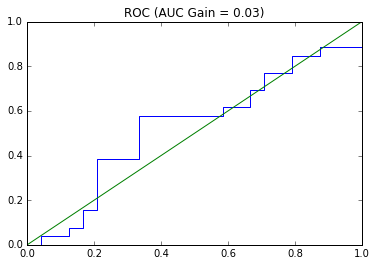

CPU times: user 252 ms, sys: 8.25 ms, total: 260 ms
Wall time: 399 ms
PRECISION/RECALL AUC


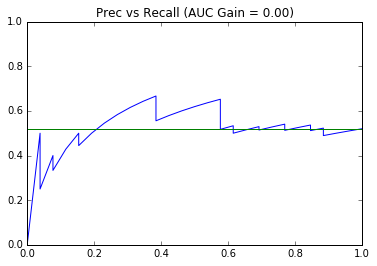

CPU times: user 287 ms, sys: 10.7 ms, total: 297 ms
Wall time: 582 ms


In [29]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 9.06 ms, sys: 3.25 ms, total: 12.3 ms
Wall time: 13.5 ms
TEST
Accuracy 0.52 Precision 0.52 Recall 1.0 F1 0.684210526316
CPU times: user 2.7 ms, sys: 965 µs, total: 3.67 ms
Wall time: 4.08 ms
TRAIN
Accuracy 1.0 Precision 1.0 Recall 1.0 F1 1.0
CPU times: user 3.61 ms, sys: 1.03 ms, total: 4.64 ms
Wall time: 5.46 ms
ROC AUC


/Users/aduriseti/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


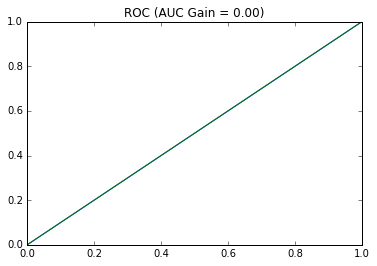

CPU times: user 312 ms, sys: 11.3 ms, total: 324 ms
Wall time: 834 ms
PRECISION/RECALL AUC


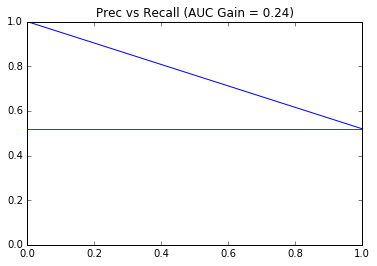

CPU times: user 306 ms, sys: 9.61 ms, total: 316 ms
Wall time: 813 ms


In [30]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

# Single tweets

In [31]:
# number of samples to train on
N = int(1e6)
X = np.array([x.T for x in df["twtvecs"][:N].values])
y = df["openup"][:N].values
# inverse classifier
# y = 1 - y

In [32]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(min(X.shape[0],N)) < ratio
pidx = ~tidx

CPU times: user 15.2 s, sys: 445 ms, total: 15.7 s
Wall time: 25.5 s
TEST
Accuracy 0.569564135622 Precision 0.567372977899 Recall 0.998316228352 F1 0.723537786559
CPU times: user 103 ms, sys: 65.6 ms, total: 169 ms
Wall time: 304 ms
TRAIN
Accuracy 0.569569586523 Precision 0.567237859081 Recall 0.998498318116 F1 0.723475712591
CPU times: user 303 ms, sys: 114 ms, total: 418 ms
Wall time: 701 ms
ROC AUC


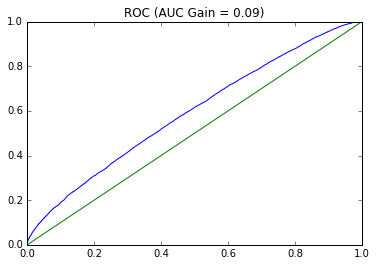

CPU times: user 365 ms, sys: 34.9 ms, total: 400 ms
Wall time: 628 ms
PRECISION/RECALL AUC


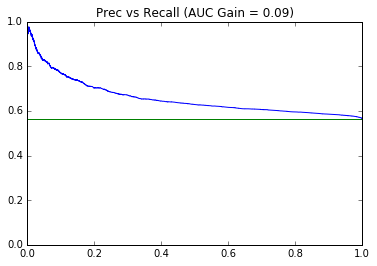

CPU times: user 407 ms, sys: 25.7 ms, total: 433 ms
Wall time: 664 ms


In [33]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 3min 47s, sys: 24.2 s, total: 4min 12s
Wall time: 6min 11s
TEST
Accuracy 0.704259121033 Precision 0.733338575866 Recall 0.747714881334 F1 0.740456954563
CPU times: user 163 ms, sys: 183 ms, total: 346 ms
Wall time: 307 ms
TRAIN
Accuracy 0.750756497979 Precision 0.772107282686 Recall 0.791686689092 F1 0.781774414386
CPU times: user 571 ms, sys: 324 ms, total: 895 ms
Wall time: 899 ms
ROC AUC


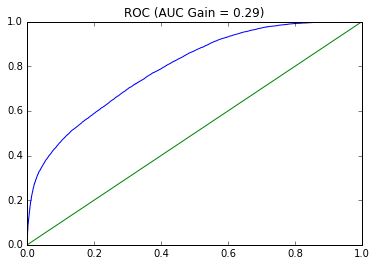

CPU times: user 375 ms, sys: 120 ms, total: 495 ms
Wall time: 450 ms
PRECISION/RECALL AUC


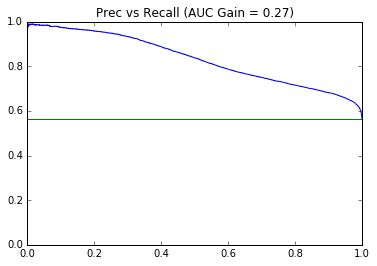

CPU times: user 359 ms, sys: 54.9 ms, total: 414 ms
Wall time: 387 ms


In [34]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 6.16 s, sys: 678 ms, total: 6.83 s
Wall time: 7.76 s
TEST
Accuracy 0.600959037344 Precision 0.661163591419 Recall 0.600465041693 F1 0.629354174545
CPU times: user 250 ms, sys: 156 ms, total: 406 ms
Wall time: 333 ms
TRAIN
Accuracy 0.61510060294 Precision 0.675069564065 Recall 0.612055502162 F1 0.642020036545
CPU times: user 1.07 s, sys: 782 ms, total: 1.85 s
Wall time: 1.9 s
ROC AUC


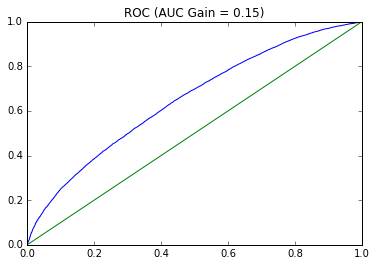

CPU times: user 441 ms, sys: 136 ms, total: 577 ms
Wall time: 566 ms
PRECISION/RECALL AUC


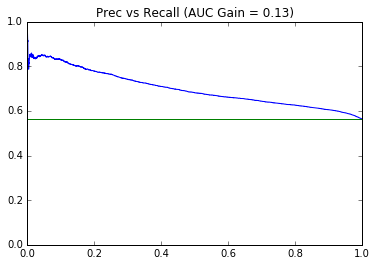

CPU times: user 459 ms, sys: 96 ms, total: 555 ms
Wall time: 512 ms


In [35]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])